# Final Project for SCC5830 (2022/1)
## Segmentation and morphological analysis applied to photos of bird droppings

Student: RRM  
nºUSP: 6516211

<div class="alert alert-block alert-danger">
<b>Warning!</b>
The images in this notebook may be disgusting to some people.
</div>

In [1]:
import numpy as np
import imageio
import matplotlib as mpl, matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

In [2]:
# from platform import python_version ; print(python_version() == '3.9.2')
# print(np.__version__ == '1.22.3')
# print(imageio.__version__ == '2.16.1')
# print(mpl.__version__ == '3.5.1')
# print(pd.__version__ == '1.3.5')
# print(sns.__version__ == '0.11.2')

### Context
Excrements (also called bird droppings) of a healthy bird consists of two phases: a long cylindrical green solid shape immerse in a heterogeneous white and translucid liquid.
This morphology is subjected to some expected variance due to random bird alimentary routines, like the quantity of water and the type of food ingested.
However, health conditions and sensibility to some kind of food may significantly disturb the usual morphology and color of the excrements, for example when occur diarrhea or bleeding.
The overall project objective is to try to detect an anomalous dropping by comparing it with a dataset composed by various healthy dropping.
Below are examples of a healthy and a diarrhea like dropping.

The dataset consists of a set of photos of healthy _psittacidae_ morning droppings taken personally by the student using a DSLR camera with the dropping placed on a clean sheet of white paper along a brown reference scale of constant and known size.

In [3]:
filename_all = glob.glob("img-db/*.JPG")
filename_test = glob.glob("img-db/*-diarrhea.JPG")
filename_train = [f for f in filename_all if f not in filename_test]
filename_test, filename_train

(['img-db/IMG_8766-diarrhea.JPG'],
 ['img-db/IMG_8789.JPG',
  'img-db/IMG_8783.JPG',
  'img-db/IMG_8798.JPG',
  'img-db/IMG_8787.JPG',
  'img-db/IMG_8780.JPG',
  'img-db/IMG_8777.JPG',
  'img-db/IMG_8795.JPG',
  'img-db/IMG_8784.JPG',
  'img-db/IMG_8792.JPG',
  'img-db/IMG_8775.JPG',
  'img-db/IMG_8791.JPG'])

Text(0.5, 1.0, 'Diarrhea')

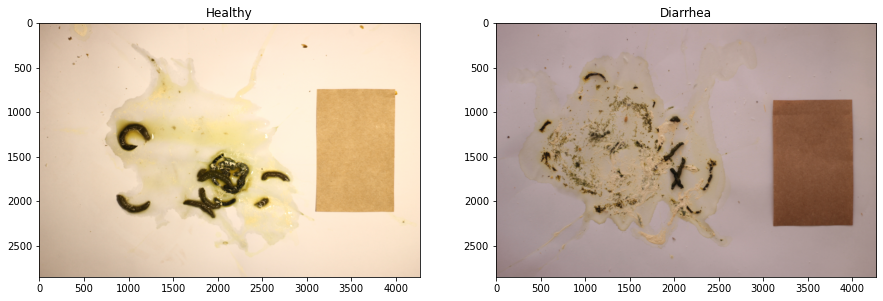

In [4]:
img_in = imageio.imread(filename_train[-1])
plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(img_in); plt.title('Healthy')
plt.subplot(122); plt.imshow(imageio.imread(filename_test[0])); plt.title('Diarrhea')

### Problem description in terms of image processing
There are two main global image processing tasks: segmentation and feature extraction.

Segmentation is necessary to:
* remove background, which contains no relevant information;
* segment the reference card, to calculate the pixel/area ratio enablin area measurements; and
* to separate the liquid and solid phases of excrement, because each phase will carry different kind of health information.

Since the colors of the regions of interest were well defined, some techniques were explored:
* K-means clustering;
* Transformation to HSV space and filter the image base on hue range of values; and
* selection based on RGB range of values.

K-means was tried, but it was abandonned due to its computational cost.
HSV transformation did not provided substatial distinction of the regions on hue channel, but the saturation channel clearly showed the background distincion.
Segmentation of the phases were done using simple selection of pixes with nearly the same color.

Unfortunatelly, the method of segmentation by saturation and color were very weak in consistency over the dataaset and each optimized value was calculated by hand previously.
Below are examples of HSV transformation and Segmentation usign both saturation and color selection.

In [5]:
# Read segmentation parameters
with open('segmentation-parameters.csv', newline='') as f:
    seg_param = pd.read_csv(f, index_col='filename')
seg_param['crgb'] = seg_param['crgb'].apply(lambda x: tuple(int(i) for i in x.strip('()').split(';')))

ref_size = 86 * 55  #[mm]  Card size
neighbour = (0, 1)  # Neighbour for coocurence matrix calculation

sat_limiar = seg_param['sat_limiar'][filename_train[-1].strip('img-db/')]
crgb = seg_param['crgb'][filename_train[-1].strip('img-db/')]
thresholdrgb = seg_param['thresholdrgb'][filename_train[-1].strip('img-db/')]
whitelvl = seg_param['whitelvl'][filename_train[-1].strip('img-db/')]

Text(0.5, 1.0, 'Value')

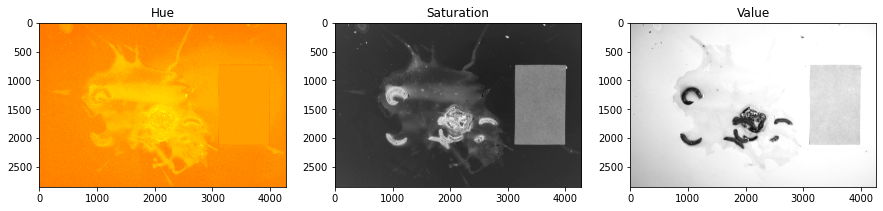

In [6]:
img_hsv = mpl.colors.rgb_to_hsv(img_in)

plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(img_hsv[:,:,0], cmap='hsv'); plt.title('Hue')
plt.subplot(132); plt.imshow(img_hsv[:,:,1], cmap='gray'); plt.title('Saturation')
plt.subplot(133); plt.imshow(img_hsv[:,:,2], cmap='gray'); plt.title('Value')

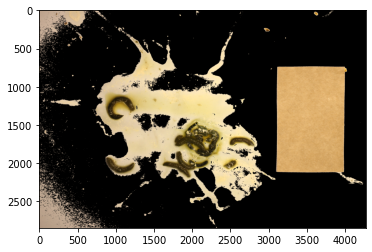

In [7]:
def remove_bg(img_in, sat_limiar):
    img_sat = mpl.colors.rgb_to_hsv(img_in)[:,:,1]
    
    bg = np.where(img_sat < sat_limiar)
    img_nobg = np.copy(img_in)
    img_nobg[bg] = 0

    return img_nobg

img_nobg = remove_bg(img_in, sat_limiar)
plt.imshow(img_nobg)

Text(0.5, 1.0, 'Without card')

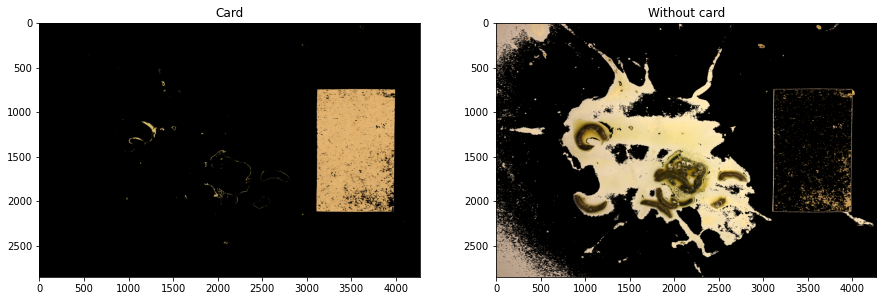

In [8]:
def get_card(img_nobg, crgb, thresholdrgb):
    condition0 = (img_nobg[:,:,0] > crgb[0] + thresholdrgb) | (img_nobg[:,:,0] < crgb[0] - thresholdrgb)
    condition1 = (img_nobg[:,:,1] > crgb[1] + thresholdrgb) | (img_nobg[:,:,1] < crgb[1] - thresholdrgb)
    condition2 = (img_nobg[:,:,2] > crgb[2] + thresholdrgb) | (img_nobg[:,:,2] < crgb[2] - thresholdrgb)
    condition = condition0 | condition1 | condition2
    notcard = np.where(condition)
    
    img_card = np.copy(img_nobg)
    img_card[notcard] = 0
    
    img_pre = np.zeros(img_nobg.shape, dtype=np.uint8)
    img_pre[notcard] = np.copy(img_nobg[notcard])
    
    return img_card, img_pre

img_card, img_pre = get_card(img_nobg, crgb, thresholdrgb)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(img_card); plt.title('Card')
plt.subplot(122); plt.imshow(img_pre); plt.title('Without card')

In [9]:
def grayscale_convert(img_in, r=0.299, g=0.587, b=0.114):
    # Default parameter values are for luminance conversion
    img_float = np.array(img_in).astype(float)
    img_lum = (r*img_float[:,:,0] + g*img_float[:,:,1] + b*img_float[:,:,2]).astype(np.uint8)
    
    return img_lum

Text(0.5, 1.0, 'Liquid phase')

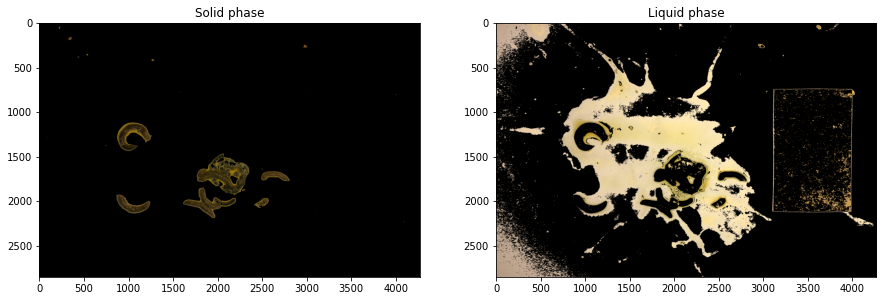

In [10]:
def segment_gray(img_pre, img_gray, whitelvl):
    solid_phase = np.where(img_gray < whitelvl)
    liquid_phase = np.where(img_gray >= whitelvl)

    img_solid = np.zeros(img_pre.shape, dtype=np.uint8)
    img_solid[solid_phase] = np.copy(img_pre[solid_phase])

    img_liquid = np.zeros(img_pre.shape, dtype=np.uint8)
    img_liquid[liquid_phase] = np.copy(img_pre[liquid_phase])
    
    return img_solid, img_liquid

img_gray = grayscale_convert(img_pre)
img_solid, img_liquid = segment_gray(img_pre, img_gray, whitelvl)

plt.figure(figsize=(15,5))
plt.subplot(121); plt.imshow(img_solid); plt.title('Solid phase')
plt.subplot(122); plt.imshow(img_liquid); plt.title('Liquid phase')

### Problem description in terms of image processing (contd.)
Some descriptors reflecting area measurement, texture information and color information were calculated.
Area measurement was made by counting pixels of the segmented card mask and comparing it with the card known size.
Texture information will try to capture diarrhea like images, in which the solid phase are scattered over large area.
Fourier tranformation and Haralick descriptors were chosen for this morphological characterization.
Color information will try to capture blood presence in the excrement, so red histogram was calculated.

In [11]:
pixel_to_area = ref_size/np.sum(img_card > 0)
print("{:.3} [mm^2/pixel]".format(pixel_to_area))

0.00139 [mm^2/pixel]


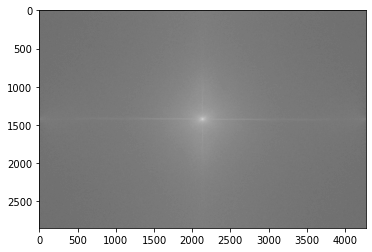

In [12]:
def fourier_transform_log(img_gray):
    spec_freq_0 = np.fft.fft2(img_gray, s=img_gray.shape)
    spec_freq_c = np.fft.fftshift(spec_freq_0)
    spec_freq_log = np.log(spec_freq_c)
    
    return spec_freq_log

freq_log = fourier_transform_log(img_gray)
plt.imshow(freq_log.real, cmap="gray")

In [13]:
def calculate_glcm(img_gray, neighbour):
    # Calculate start and end indexes to avoid undefined neighbours
    x_start =  1 if neighbour[0] == -1 else 0
    x_end = -1 if neighbour[0] == 1 else img_gray.shape[0]
    y_start = 1 if neighbour[1] == -1 else 0
    y_end = -1 if neighbour[1] == 1 else img_gray.shape[1]

    shifted_img = np.roll(img_gray, (0-neighbour[0],0-neighbour[1]), axis=(0,1))  # Places the neighbour above the ref position
    glcm = np.histogram2d(np.ravel(   img_gray[x_start : x_end, y_start : y_end]), \
                          np.ravel(shifted_img[x_start : x_end, y_start : y_end]), \
                          bins=256, range=[[0,256],[0,256]])
    glcm_norm = glcm[0]/np.sum(glcm[0])

    return glcm_norm

In [14]:
def haralick(glcm_norm):  # Calculate Haralick descriptors
    im = np.array([glcm_norm.shape[0]*[i] for i in range(glcm_norm.shape[0])])
    jm = np.array([glcm_norm.shape[1]*[j] for j in range(glcm_norm.shape[1])])
    
    auto_cor = np.sum(np.multiply(np.multiply(im, jm),glcm_norm))
    contrast = np.sum(np.multiply((im - jm)**2 , glcm_norm))
    dissim   = np.sum(np.multiply(np.abs(im - jm),glcm_norm))
    energy   = np.sum(glcm_norm**2)
    entropy  = np.sum((-1)*np.multiply(glcm_norm[glcm_norm.nonzero()],np.log(glcm_norm[glcm_norm.nonzero()])))
    homog    = np.sum(np.divide(glcm_norm, (1+(im-jm)**2)))
    inv_dif  = np.sum(np.divide(glcm_norm, (1+np.abs(im-jm))))
    max_prob = np.max(glcm_norm)
    
    return {'auto_cor': auto_cor, 'contrast': contrast, 'dissim': dissim,
             'energy': energy, 'entropy': entropy, 'homog': homog,
             'inv_dif': inv_dif, 'max_prob': max_prob}

glcm_norm = calculate_glcm(img_gray, neighbour)
haralick(glcm_norm)

{'auto_cor': 8756.017969783803,
 'contrast': 0.0,
 'dissim': 0.0,
 'energy': 0.5835227364702333,
 'entropy': 2.147195832089503,
 'homog': 0.9999999999999999,
 'inv_dif': 0.9999999999999999,
 'max_prob': 0.7637934600743451}

(0.0, 255.0)

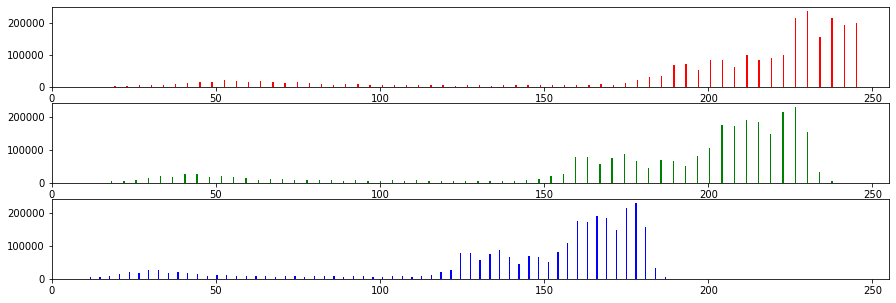

In [15]:
### Color histograms
img_r = img_pre[:,:,0]
img_g = img_pre[:,:,1]
img_b = img_pre[:,:,2]

hist_r = np.histogram(img_r[(img_r > 5) & (img_r < 250)], bins=64)
hist_g = np.histogram(img_g[(img_g > 5) & (img_g < 250)], bins=64)
hist_b = np.histogram(img_b[(img_b > 5) & (img_b < 250)], bins=64)

plt.figure(figsize=(15,5))
plt.subplot(311); plt.bar(hist_r[1][:-1]-0.2,hist_r[0], 0.4, color='red'); plt.xlim([0,255])
plt.subplot(312); plt.bar(hist_g[1][:-1]-0.2,hist_g[0], 0.4, color='green'); plt.xlim([0,255])
plt.subplot(313); plt.bar(hist_b[1][:-1]-0.2,hist_g[0], 0.4, color='blue'); plt.xlim([0,255])

### Problem description in terms of image processing (contd.)
All measurements from all dataset of healthy droppings will be gathered to compose normality curves on each descriptor, which may be useful for the detection of future anomalous droppings that might significantly deviate from the expected values.

In [16]:
# Calculate descriptors for all dataset
df = pd.DataFrame(columns=['area_total', 'area_proportion', 'haralick_auto_cor',
                           'haralick_energy', 'haralick_entropy', 'haralick_max_prob'],
                  index=filename_all)
df_vectors = pd.DataFrame(columns=['hist_b_liquid', 'freq_log_solid',
                                   'hist_r_solid', 'hist_g_solid'],
                          index=filename_all)
con, ntotal = 1, str(len(filename_all))
for filename in filename_all:
    print('\nPROCESSING ('+str(con)+'/'+ntotal+') '+ filename + ':')
    
    print('...reading inputs')
    img_in = (imageio.imread(filename)).astype(np.uint8)
    sat_limiar = seg_param['sat_limiar'][filename.strip('img-db/')]
    crgb = seg_param['crgb'][filename.strip('img-db/')]
    thresholdrgb = seg_param['thresholdrgb'][filename.strip('img-db/')]
    whitelvl = seg_param['whitelvl'][filename.strip('img-db/')]
    
    print('...removing background')
    img_nobg = remove_bg(img_in, sat_limiar)

    print('...segmenting ref card')
    img_card, img_pre = get_card(img_nobg, crgb, thresholdrgb)

    print('...calculating pixel to area ratio from reference card size')
    pixel_to_area = ref_size/np.sum(img_card > 0)
    
    print('...converting to luminance grayscale')
    img_gray = grayscale_convert(img_pre)
    
    print('...segmenting solid and liquid phases')
    img_solid, img_liquid = segment_gray(img_pre, img_gray, whitelvl)
    

    print('DESCRIPTORS FOR THE WHOLE DROPPING' + ':')
    print('...calculating total area')
    area_total = pixel_to_area * np.sum(img_gray > 0)
    
    print('...calculating Haralick descriptors')
    glcm_norm = calculate_glcm(img_gray, neighbour)
    desc = haralick(glcm_norm)


    print('DESCRIPTORS FOR THE LIQUID PHASE' + ':')
    print('...calculating area of liquid')
    area_liquid = pixel_to_area * np.sum(img_liquid > 0)
    
    print('...calculating blue histogram of liquid phase')
    img_b_l = img_liquid[:,:,2]
    hist_b_liquid, bin_edges = np.histogram(img_b_l[(img_b_l > 5) & (img_b_l < 250)], bins=64, range=(0,255))
    
    
    print('DESCRIPTORS FOR THE SOLID PHASE' + ':')
    print('...calculating area of solid and the proportion between solid and liquid')
    area_solid = pixel_to_area * np.sum(img_solid > 0)
    area_proportion = area_solid/area_liquid

    print('...converting solid phase to luminance grayscale')
    img_gray_solid = grayscale_convert(img_solid)
    
    print('...calculating Fourier transformation for solid phase')
    freq_log_solid = fourier_transform_log(img_gray_solid)
    
    print('...calculating red and green histograms of solid phase')
    img_r_s = img_solid[:,:,0]
    img_g_s = img_solid[:,:,1]
    hist_r_solid, bin_edges = np.histogram(img_r_s[(img_r_s > 5) & (img_r_s < 250)], bins=64, range=(0,255))
    hist_g_solid, bin_edges = np.histogram(img_g_s[(img_g_s > 5) & (img_g_s < 250)], bins=64, range=(0,255))
    
    print('...assembling the dataset of descriptors')
    df['area_total'][filename] = area_total
    df['haralick_auto_cor'][filename] = desc['auto_cor']
    df['haralick_energy'][filename] = desc['energy']
    df['haralick_entropy'][filename] = desc['entropy']
    df['haralick_max_prob'][filename] = desc['max_prob']
    df['area_proportion'][filename] = area_proportion
    df_vectors['hist_b_liquid'][filename] = hist_b_liquid
    df_vectors['freq_log_solid'][filename] = freq_log_solid.real
    df_vectors['hist_r_solid'][filename] = hist_r_solid
    df_vectors['hist_g_solid'][filename] = hist_g_solid
    
    con += 1

print('\nEND OF DESCRIPTORS CALCULATIONS FOR ALL DATASET')


PROCESSING (1/12) img-db/IMG_8789.JPG:
...reading inputs
...removing background
...segmenting ref card
...calculating pixel to area ratio from reference card size
...converting to luminance grayscale
...segmenting solid and liquid phases
DESCRIPTORS FOR THE WHOLE DROPPING:
...calculating total area
...calculating Haralick descriptors
DESCRIPTORS FOR THE LIQUID PHASE:
...calculating area of liquid
...calculating blue histogram of liquid phase
DESCRIPTORS FOR THE SOLID PHASE:
...calculating area of solid and the proportion between solid and liquid
...converting solid phase to luminance grayscale
...calculating Fourier transformation for solid phase
...calculating red and green histograms of solid phase
...assembling the dataset of descriptors

PROCESSING (2/12) img-db/IMG_8783.JPG:
...reading inputs
...removing background
...segmenting ref card
...calculating pixel to area ratio from reference card size
...converting to luminance grayscale
...segmenting solid and liquid phases
DESCRIPTO

In [17]:
df.head(2)

,area_total,area_proportion,haralick_auto_cor,haralick_energy,haralick_entropy,haralick_max_prob
img-db/IMG_8789.JPG,4877.509556,0.408778,7631.981195,0.530653,2.586622,0.728392
img-db/IMG_8783.JPG,3288.690703,0.179887,9351.464278,0.531521,2.377247,0.728873


In [18]:
df_vectors.head(2)

,hist_b_liquid,freq_log_solid,hist_r_solid,hist_g_solid
img-db/IMG_8789.JPG,"[0, 0, 0, 0, 0, 0, 5, 12, 18, 17, 33, 58, 126,...","[[9.40804303080844, 9.60943358943457, 10.27512...","[0, 12, 681, 2185, 6727, 12559, 25535, 38000, ...","[0, 188, 1502, 7998, 15821, 29021, 44209, 5896..."
img-db/IMG_8783.JPG,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 24, 91, 227,...","[[7.593374193121286, 8.76957607852029, 8.51142...","[0, 0, 0, 0, 0, 13, 30, 64, 99, 246, 957, 2346...","[0, 0, 1, 32, 218, 1260, 3870, 6338, 8585, 118..."


In [19]:
# Compose the normality curve from distances to centroids of vectors
## Centroid of vectors
df_vectors['mean_hist_b_liquid'] = [df_vectors['hist_b_liquid'][filename_train].mean() for _ in range(len(df))]
df_vectors['mean_freq_log_solid'] = [df_vectors['freq_log_solid'][filename_train].mean() for _ in range(len(df))]
df_vectors['mean_hist_r_solid'] = [df_vectors['hist_r_solid'][filename_train].mean() for _ in range(len(df))]
df_vectors['mean_hist_g_solid'] = [df_vectors['hist_g_solid'][filename_train].mean() for _ in range(len(df))]

## Calculation of distances
df_vectors['dist_hist_b_liquid'] = (df_vectors['hist_b_liquid'] - df_vectors['mean_hist_b_liquid'])**2
df['dist_hist_b_liquid'] = df_vectors['dist_hist_b_liquid'].apply(lambda x: np.sqrt(np.sum(x)))
df_vectors['dist_freq_log_solid'] = (df_vectors['freq_log_solid'] - df_vectors['mean_freq_log_solid'])**2
df['dist_freq_log_solid'] = df_vectors['dist_freq_log_solid'].apply(lambda x: np.sqrt(np.sum(x)))
df_vectors['dist_hist_r_solid'] = (df_vectors['hist_r_solid'] - df_vectors['mean_hist_r_solid'])**2
df['dist_hist_r_solid'] = df_vectors['dist_hist_r_solid'].apply(lambda x: np.sqrt(np.sum(x)))
df_vectors['dist_hist_g_solid'] = (df_vectors['hist_g_solid'] - df_vectors['mean_hist_g_solid'])**2
df['dist_hist_g_solid'] = df_vectors['dist_hist_g_solid'].apply(lambda x: np.sqrt(np.sum(x)))

In [20]:
df.head(4)

,area_total,area_proportion,haralick_auto_cor,haralick_energy,haralick_entropy,haralick_max_prob,dist_hist_b_liquid,dist_freq_log_solid,dist_hist_r_solid,dist_hist_g_solid
img-db/IMG_8789.JPG,4877.509556,0.408778,7631.981195,0.530653,2.586622,0.728392,249495.631256,2367.363399,102631.078637,112977.570853
img-db/IMG_8783.JPG,3288.690703,0.179887,9351.464278,0.531521,2.377247,0.728873,273553.600573,2160.483361,46591.811706,34113.121821
img-db/IMG_8798.JPG,15936.961403,0.206559,3674.694847,0.489442,2.890181,0.699552,689869.007998,2220.396849,99219.747674,113319.652120
img-db/IMG_8766-diarrhea.JPG,4868.126168,0.10891,7778.641904,0.457339,2.553266,0.675758,741266.980263,2991.983393,103356.679835,80012.126160


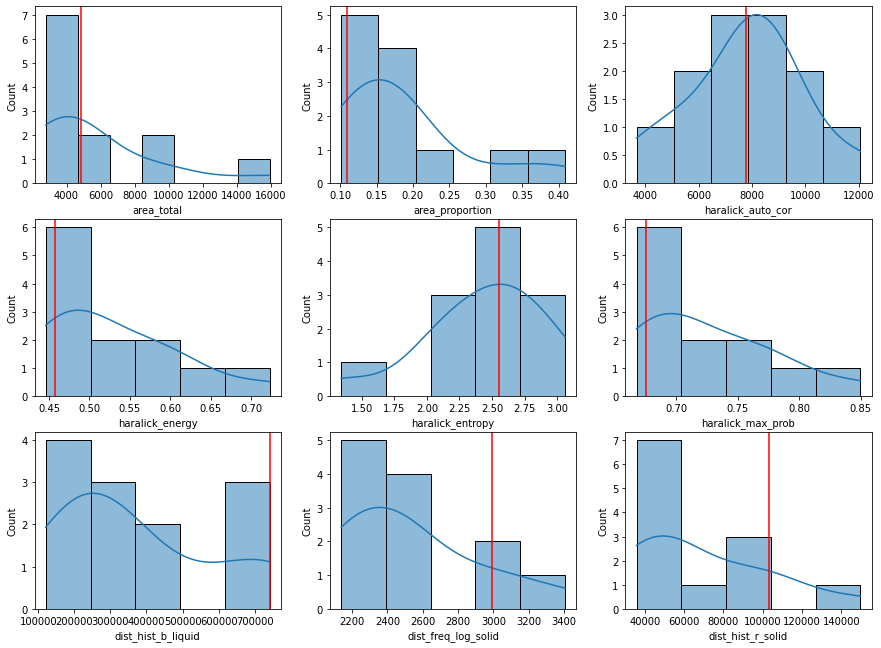

In [21]:
# Plot descriptors histograms and compare the test case
plt.figure(figsize=(15,15))
plt.subplot(431); sns.histplot(data=df, x='area_total', kde=True)
plt.axvline(df['area_total'][filename_test[0]], 0,10, c='red')
plt.subplot(432); sns.histplot(data=df, x='area_proportion', kde=True)
plt.axvline(df['area_proportion'][filename_test[0]], 0,10, c='red')
plt.subplot(433); sns.histplot(data=df, x='haralick_auto_cor', kde=True)
plt.axvline(df['haralick_auto_cor'][filename_test[0]], 0,10, c='red')
plt.subplot(434); sns.histplot(data=df, x='haralick_energy', kde=True)
plt.axvline(df['haralick_energy'][filename_test[0]], 0,10, c='red')
plt.subplot(435); sns.histplot(data=df, x='haralick_entropy', kde=True)
plt.axvline(df['haralick_entropy'][filename_test[0]], 0,10, c='red')
plt.subplot(436); sns.histplot(data=df, x='haralick_max_prob', kde=True)
plt.axvline(df['haralick_max_prob'][filename_test[0]], 0,10, c='red')
plt.subplot(437); sns.histplot(data=df, x='dist_hist_b_liquid', kde=True)
plt.axvline(df['dist_hist_b_liquid'][filename_test[0]], 0,10, c='red')
plt.subplot(438); sns.histplot(data=df, x='dist_freq_log_solid', kde=True)
plt.axvline(df['dist_freq_log_solid'][filename_test[0]], 0,10, c='red')
plt.subplot(439); sns.histplot(data=df, x='dist_hist_r_solid', kde=True)
plt.axvline(df['dist_hist_r_solid'][filename_test[0]], 0,10, c='red')
#plt.subplot(439); sns.histplot(data=df, x='dist_hist_g_solid', kde=True)  # Subplot only allows 9
#plt.axvline(df['dist_hist_g_solid'][filename_test[0]], 0,10, c='red')

### Conclusions
The normality curves/histograms of healthy droppings were done and the comparisson with a test case was made, but showed very low capacity of anomaly detection, unfortunatelly, even with input images captured in a reasonable controled environment.
However, there are several points to be improved in the project:
* the selected methods of segmentation left notable noise for some photos;
* color calibration and normalization should be made in the light of reference card along the dataset to try to reduce noise of segmentation steps and reduce variance in final histograms, thus improving the margin for detection;
* several Haralick descritors (contrast, dissimilarity, homogeneity and inverse diference) showed constant values for all dataset and this should be investigated;
* the dataset should be supplemented with more photos to improve statistical power.